## Project - Group 1
**Topic** - Feature Extraction from satellite images before and after disaster(Hurricane)
Ritik Kumar Singh - AM.EN.U4CSE20061

In [1]:
import os
import math
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
input_path = 'E:/Codes/Pattern Recognition/Dataset/'

def print_file_sizes(input_path, subset):
    print('{}:'.format(subset))
    print('')
    path = input_path + subset + '/'
    for f in os.listdir(path):
        if not os.path.isdir(path + f):
            print(f.ljust(30) + str(round(os.path.getsize(path + f) / 1000000, 2)) + 'MB')
        else:
            sizes = [os.path.getsize(path+f+'/'+x)/1000000 for x in os.listdir(path + f)]
            print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))
    print('')

print_file_sizes(input_path, 'train_another')
print_file_sizes(input_path, 'validation_another')
print_file_sizes(input_path, 'test_another')
print_file_sizes(input_path, 'test')

train_another:

damage                        12.56MB (5000 files)
no_damage                     15.07MB (5000 files)

validation_another:

damage                        2.52MB (1000 files)
no_damage                     3.02MB (1000 files)

test_another:

damage                        20.12MB (8000 files)
no_damage                     3.01MB (1000 files)

test:

damage                        2.53MB (1000 files)
no_damage                     2.99MB (1000 files)


# Training Labels

All labels for the images are encoded into the directory structure of this dataset. Just extract it into a pandas DataFrame:

In [3]:
image_df = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})

image_df['damage'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['data_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['location'] = image_df['path'].map(lambda x: x.stem)
image_df['lon'] = image_df['location'].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[-1]))
image_df['path'] = image_df['path'].map(lambda x: str(x)) # convert the path back to a string

image_df.head()

,path,damage,data_split,location,lon,lat
0,E:\Codes\Pattern Recognition\Dataset\test\dama...,damage,test,-93.548123_30.900623,-93.548123,30.900623
1,E:\Codes\Pattern Recognition\Dataset\test\dama...,damage,test,-93.560128_30.894917,-93.560128,30.894917
2,E:\Codes\Pattern Recognition\Dataset\test\dama...,damage,test,-93.578271_30.779923999999998,-93.578271,30.779924
3,E:\Codes\Pattern Recognition\Dataset\test\dama...,damage,test,-93.590598_30.694956,-93.590598,30.694956
4,E:\Codes\Pattern Recognition\Dataset\test\dama...,damage,test,-93.604017_30.793719,-93.604017,30.793719


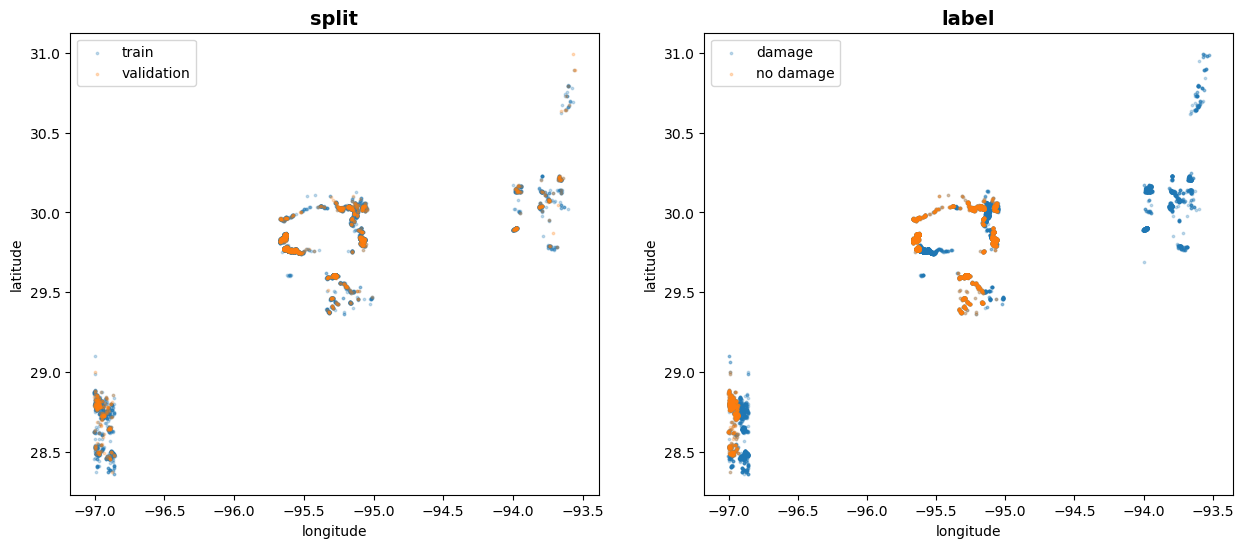

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

s = 3
alpha = 0.25

# get the train-validation-test splits
image_df_train = image_df[image_df['data_split']=='train_another'].copy()
image_df_val = image_df[image_df['data_split']=='validation_another'].copy()
image_df_test = image_df[image_df['data_split']=='test_another'].copy()

# sort to ensure reproducible behaviour
image_df_train.sort_values('lat', inplace=True)
image_df_val.sort_values('lat', inplace=True)
image_df_test.sort_values('lat', inplace=True)
image_df_train.reset_index(drop=True,inplace=True)
image_df_val.reset_index(drop=True,inplace=True)
image_df_test.reset_index(drop=True,inplace=True)

ax[0].scatter(image_df_train['lon'], image_df_train['lat'], color='C0', s=s, alpha=alpha, label='train')
ax[0].scatter(image_df_val['lon'], image_df_val['lat'], color='C1', s=s, alpha=alpha, label='validation')

ax[0].set_title('split', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

image_df_dmg = image_df[image_df['damage']=='damage'].copy()
image_df_nodmg = image_df[image_df['damage']=='no_damage'].copy()

image_df_dmg.reset_index(drop=True,inplace=True)
image_df_nodmg.reset_index(drop=True,inplace=True)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')

ax[1].set_title('label', fontsize=14, fontweight='bold')
ax[1].legend()
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('latitude')

plt.show(fig)

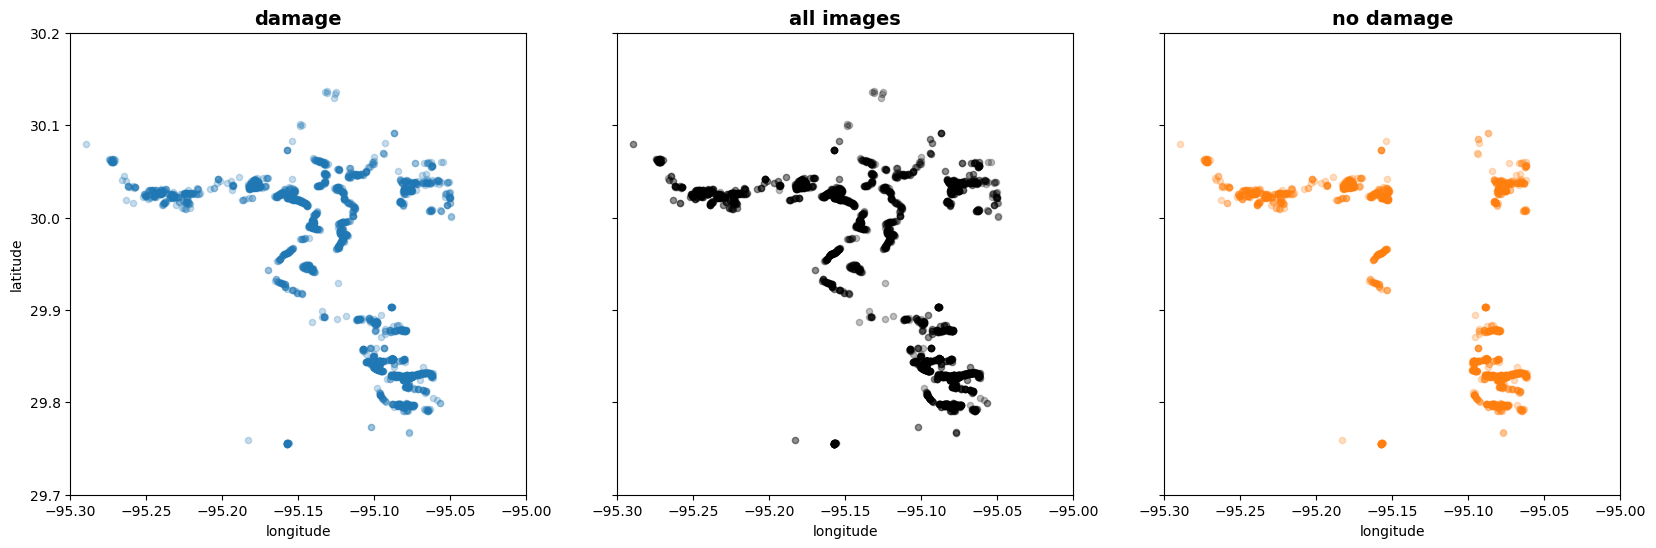

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6), sharex=True, sharey=True)

s = 20
alpha = 0.25

ax[0].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C0', s=s, alpha=alpha, label='damage')
ax[0].set_title('damage', fontsize=14, fontweight='bold')

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='k', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='k', s=s, alpha=alpha, label='no damage')
ax[1].set_title('all images', fontsize=14, fontweight='bold')

ax[2].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C1', s=s, alpha=alpha, label='no damage')
ax[2].set_title('no damage', fontsize=14, fontweight='bold')

ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[2].set_xlabel('longitude')

ax[0].set_xlim(-95.3,-95)
ax[0].set_ylim(29.7,30.2)

plt.show(fig)

# Training Images

First, inspect the images:

In [6]:
# read it in unchanged, to make sure we aren't losing any information
img = cv2.imread(image_df['path'][0], cv2.IMREAD_UNCHANGED)
np.shape(img)

(128, 128, 3)

In [7]:
type(img[0,0,0])

numpy.uint8

In [8]:
np.min(img[:,:,:])

0

In [9]:
np.max(img[:,:,:])

255

Let's plot a few (note that OpenCV reads the image in as BGR):

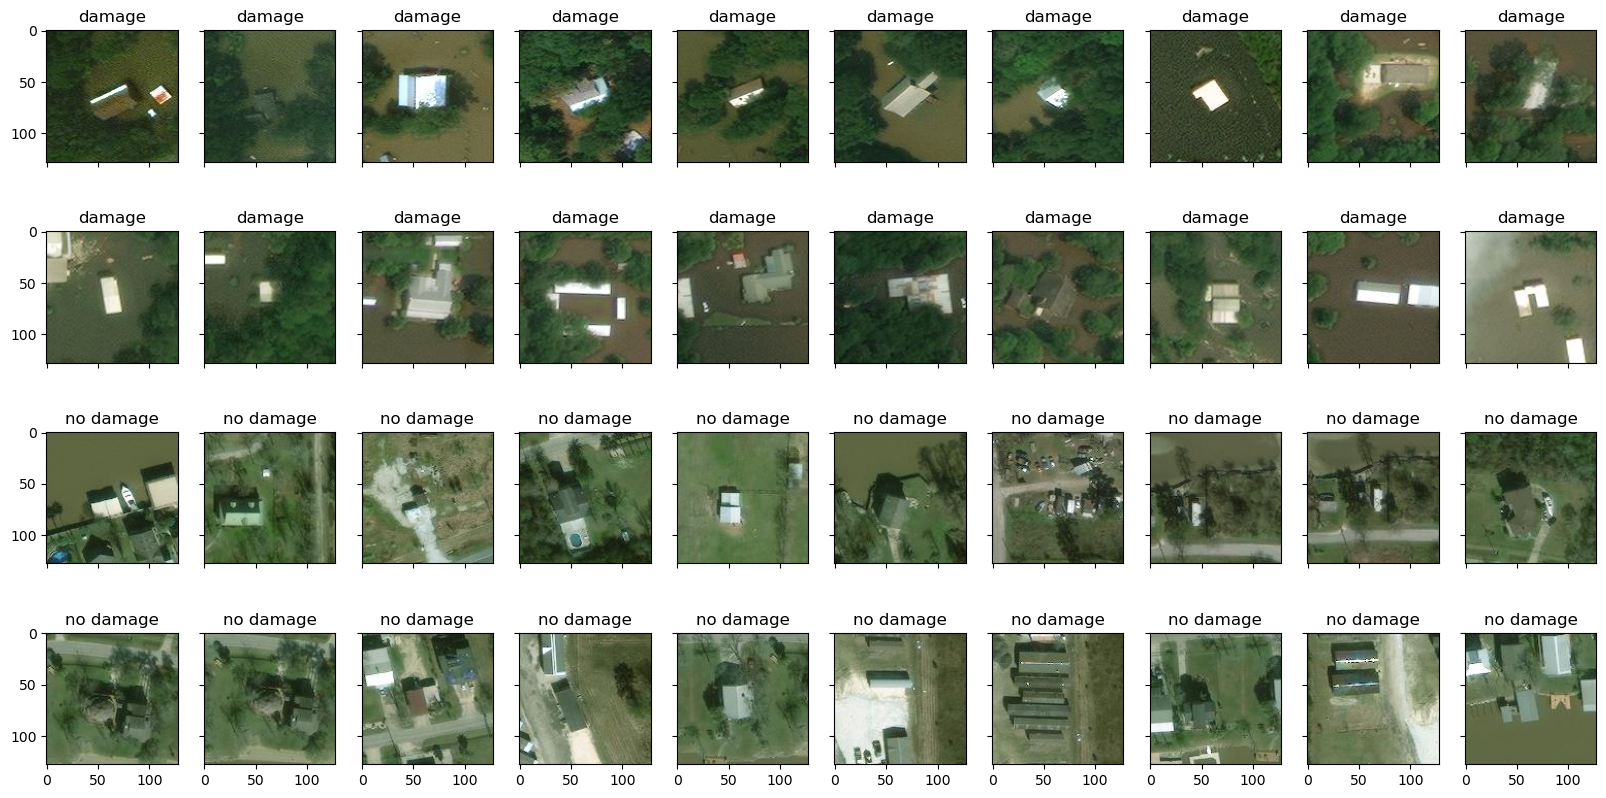

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=10, sharex=True, sharey=True, figsize=(20,10))

ax = ax.flatten()

for i in range(20):
    img = cv2.imread(image_df_dmg['path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('damage')

for i in range(20,40):
    img = cv2.imread(image_df_nodmg['path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('no damage')

plt.show()

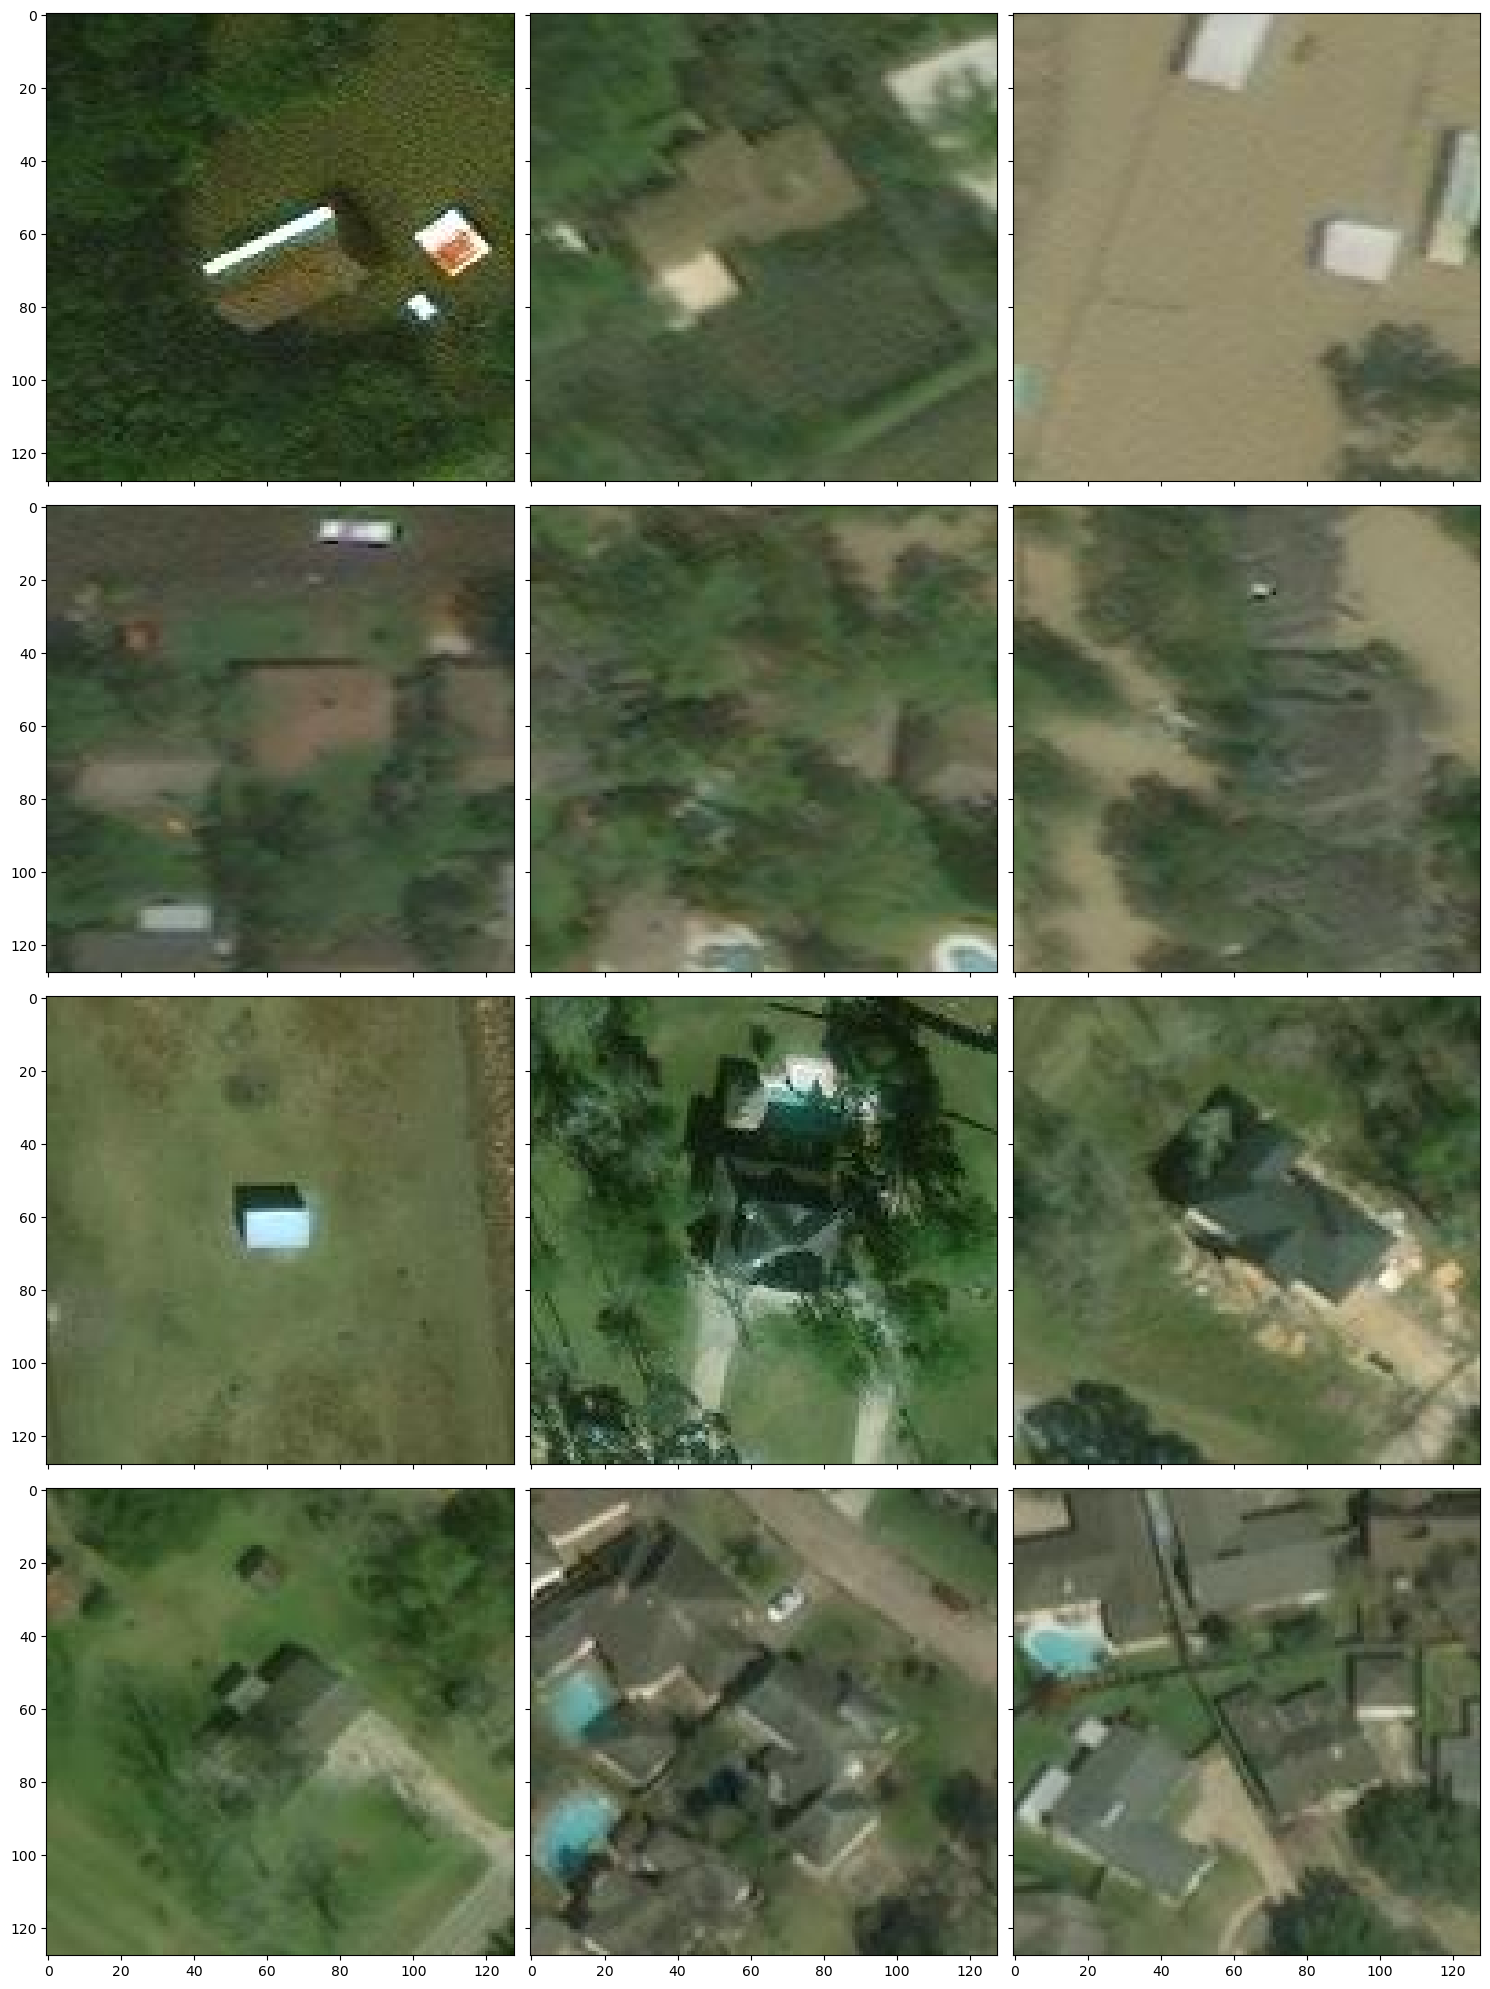

In [11]:
fig, ax = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(15,20))

ax = ax.flatten()

selected_dmg = np.array([0,1,2,3,4,5])*100
selected_nodmg = np.array([0,1,2,3,4,5])*99

for i in range(6):
    img = cv2.imread(image_df_dmg['path'][selected_dmg[i]], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #ax[i].set_title('damage')

for i in range(6):
    img = cv2.imread(image_df_nodmg['path'][selected_nodmg[i]], cv2.IMREAD_UNCHANGED)
    ax[i+6].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #ax[i+6].set_title('no damage')

fig.tight_layout()
plt.show()

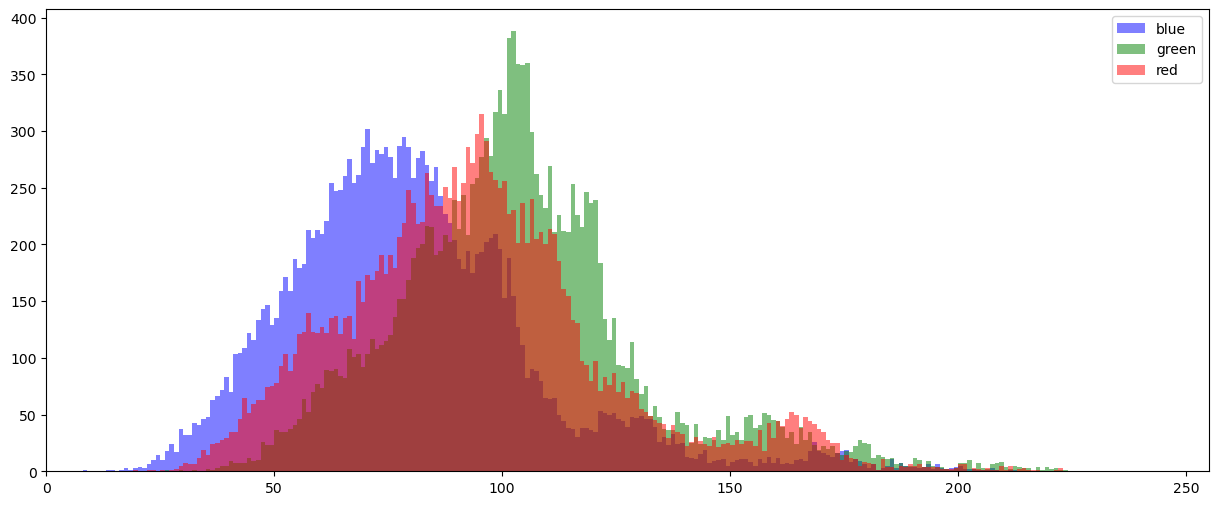

In [12]:
jpg_channels = ['blue','green','red']
jpg_channel_colors = ['b','g','r']

fig, ax = plt.subplots(figsize=(15,6))

for i in range(len(jpg_channels)):
    ax.hist(img[:,:,i].flatten(), bins=np.arange(256),
            label=jpg_channels[i], color=jpg_channel_colors[i], alpha=0.5)
    ax.legend()

ax.set_xlim(0,255)

plt.show(fig)

In [13]:
import tensorflow as tf
tf.__version__

'2.10.1'

# Image Preprocessing

We could use `tf.keras.preprocessing` to load the images, but it has 3 downsides:

1. it's slow
2. it lacks fine-grained control
3. it's not well integrated with the rest of TensorFlow

Hence, just for sake of using we will use the `tf.data.Dataset` API.

In [14]:
# paths
train_path = image_df_train['path'].copy().values
val_path = image_df_val['path'].copy().values
test_path = image_df_test['path'].copy().values

# labels
train_labels = np.zeros(len(image_df_train), dtype=np.int8)
train_labels[image_df_train['damage'].values=='damage'] = 1

val_labels = np.zeros(len(image_df_val), dtype=np.int8)
val_labels[image_df_val['damage'].values=='damage'] = 1

test_labels = np.zeros(len(image_df_test), dtype=np.int8)
test_labels[image_df_test['damage'].values=='damage'] = 1

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_path, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_path, test_labels))

# note that the `numpy()` function is required to grab the actual values from the Dataset
for path, label in train_ds.take(5):
    print("path  : ", path.numpy().decode('utf-8'))
    print("label : ", label.numpy())

path  :  E:\Codes\Pattern Recognition\Dataset\train_another\damage\-96.860867_28.363774.jpeg
label :  1
path  :  E:\Codes\Pattern Recognition\Dataset\train_another\damage\-96.861175_28.36379.jpeg
label :  1
path  :  E:\Codes\Pattern Recognition\Dataset\train_another\damage\-96.90485699999999_28.375248.jpeg
label :  1
path  :  E:\Codes\Pattern Recognition\Dataset\train_another\damage\-96.905101_28.375287.jpeg
label :  1
path  :  E:\Codes\Pattern Recognition\Dataset\train_another\damage\-96.90476600000001_28.375337.jpeg
label :  1


# Feature Extraction

## Histogram of Oriented Gradients(HOG) Feature extraction
Explanation: https://www.thepythoncode.com/article/hog-feature-extraction-in-python
Github: https://github.com/danielshaving/CV_Features_HoG_Feature_Extraction

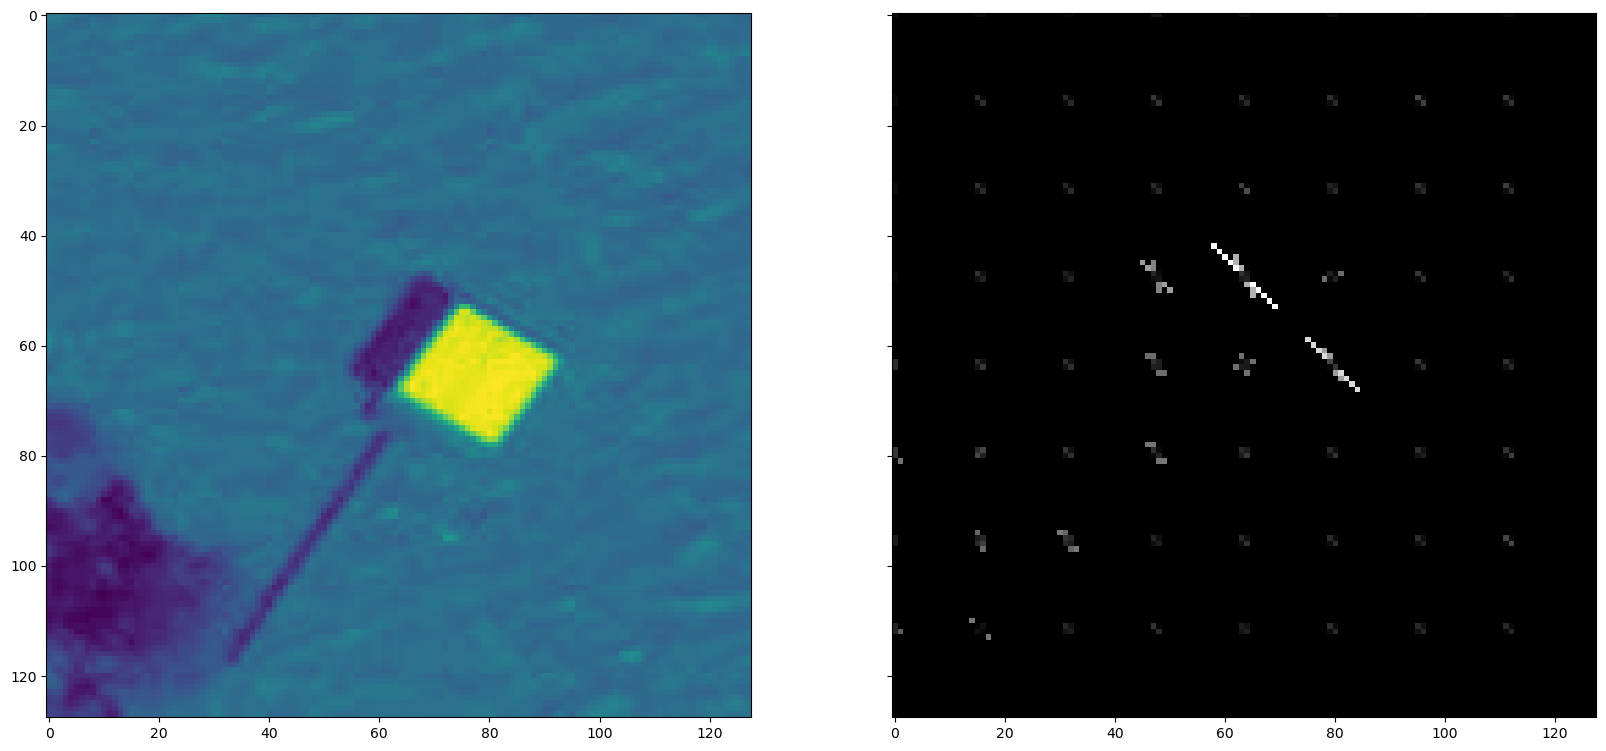

In [16]:
import math
class Hog_descriptor():
    def __init__(self, img, cell_size=16, bin_size=8):
        self.img = img
        self.img = np.sqrt(img / float(np.max(img)))
        self.img = self.img * 255
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.angle_unit = 360 / self.bin_size
        assert type(self.bin_size) == int, "bin_size should be integer,"
        assert type(self.cell_size) == int, "cell_size should be integer,"
        #assert type(self.angle_unit) == int, "bin_size should be divisible by 360"

    def extract(self):
        height, width = self.img.shape
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)
        cell_gradient_vector = np.zeros((int(height / self.cell_size), int(width / self.cell_size), self.bin_size))
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)

        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        hog_vector = []
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image

    def global_gradient(self):
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
        gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
        return gradient_magnitude, gradient_angle

    def cell_gradient(self, cell_magnitude, cell_angle):
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers

    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        if idx == self.bin_size:
            return idx - 1, (idx) % self.bin_size, mod
        return idx, (idx + 1) % self.bin_size, mod

    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
        return image

img = cv2.imread('E:/Codes/Pattern Recognition/Dataset/train_another/no_damage/-95.1624_29.929733000000002.jpeg', cv2.IMREAD_GRAYSCALE)
hog = Hog_descriptor(img, cell_size=16, bin_size=16)
vector, image = hog.extract()
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,10))
ax[1].imshow(image, cmap='gray')
ax[0].imshow(img)
plt.show()


## Local Binary Patterns(LBG) Feature extraction
Explanation: https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

LBP Program is finished


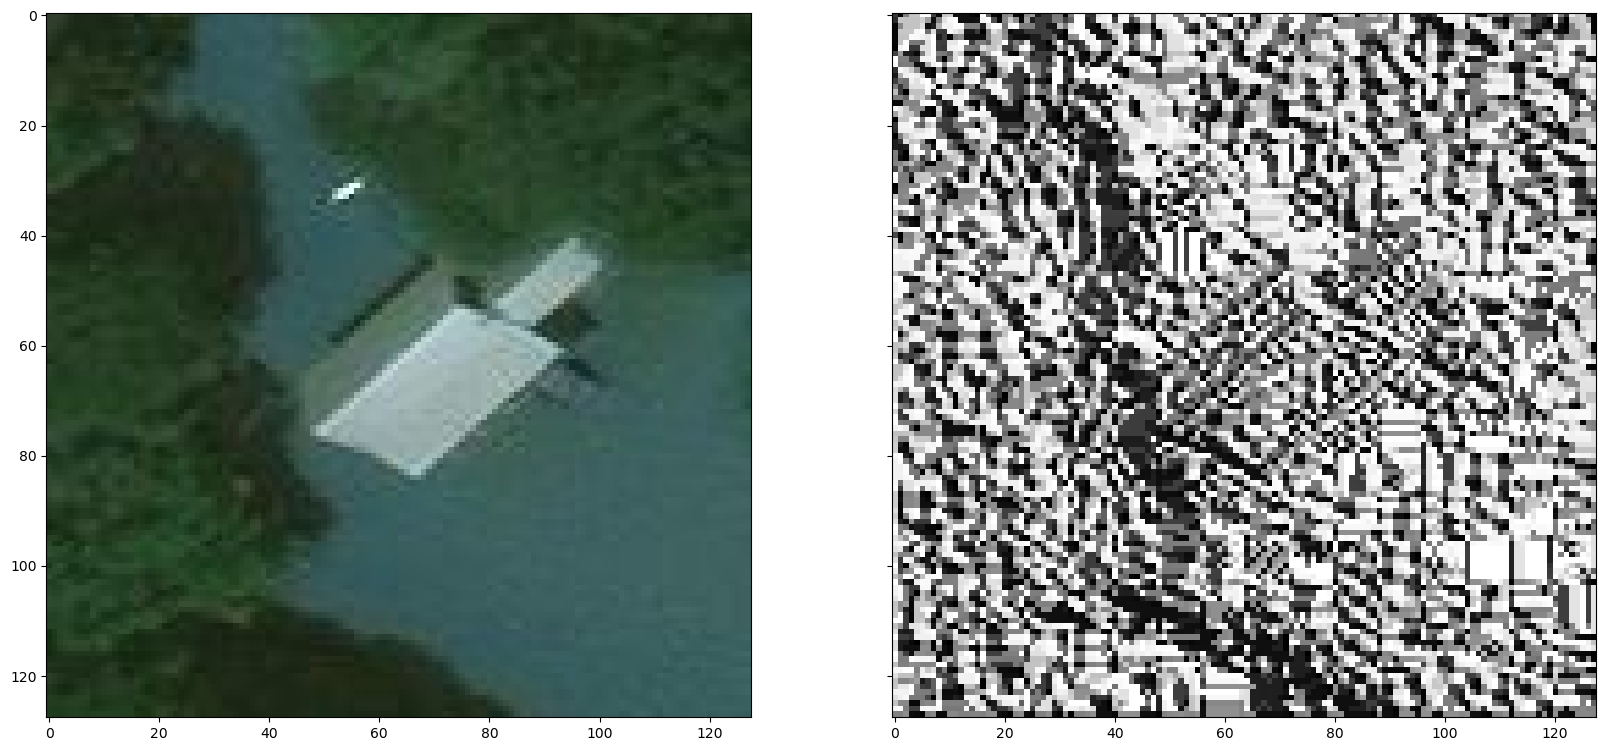

In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def get_pixel(img, center, x, y):

    new_value = 0

    try:
        # If local neighbourhood pixel
        # value is greater than or equal
        # to center pixel values then
        # set it to 1
        if img[x][y] >= center:
            new_value = 1

    except:
        # Exception is required when
        # neighbourhood value of a center
        # pixel value is null i.e. values
        # present at boundaries.
        pass

    return new_value

# Function for calculating LBP
def lbp_calculated_pixel(img, x, y):

    center = img[x][y]

    val_ar = []

    # top_left
    val_ar.append(get_pixel(img, center, x-1, y-1))

    # top
    val_ar.append(get_pixel(img, center, x-1, y))

    # top_right
    val_ar.append(get_pixel(img, center, x-1, y + 1))

    # right
    val_ar.append(get_pixel(img, center, x, y + 1))

    # bottom_right
    val_ar.append(get_pixel(img, center, x + 1, y + 1))

    # bottom
    val_ar.append(get_pixel(img, center, x + 1, y))

    # bottom_left
    val_ar.append(get_pixel(img, center, x + 1, y-1))

    # left
    val_ar.append(get_pixel(img, center, x, y-1))

    # Now, we need to convert binary
    # values to decimal
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]

    val = 0

    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]

    return val

path = 'E:/Codes/Pattern Recognition/Dataset/test/damage/-93.6141_30.754263.jpeg'
img_bgr = cv2.imread(path, 1)

height, width, _ = img_bgr.shape

# We need to convert RGB image
# into gray one because gray
# image has one channel only.
img_gray = cv2.cvtColor(img_bgr,
                        cv2.COLOR_BGR2GRAY)

# Create a numpy array as
# the same height and width
# of RGB image
img_lbp = np.zeros((height, width),
                   np.uint8)

for i in range(0, height):
    for j in range(0, width):
        img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,10))
ax[1].imshow(img_lbp, cmap='gray')
ax[0].imshow(img_bgr)
print("LBP Program is finished")


## Gabor Filters: Feature extraction
Explanation: https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97
Github: https://github.com/Rohit-Kundu/Traditional-Feature-Extraction

*Bandwidth:* Narrower bandwidth is desirable because they make finer distinction in texture. In this implementation, we have determined the value of bandwidth using energy density of image. The higher the energy density, the lesser the bandwidth so that more textured areas do not overpower less textured areas.

*Theta:* Theta represents the orientation of the gabor filter. In this implementation, we have used six orientations from 0 degree to 150 degree with a seperation of 30 degree each. Instead of this, we can also take an orientation seperation of 45 degree but, this would not produce as good results.

*Frequency*: According to this, for an orientation seperation of 30 degree, the total number of gabor filters required is: 6log2(Nc/2) where, Nc is the width of the image. The frequencies that should be used are: 1sqrt(2), 2sqrt(2), 4sqrt(2) ... Nc/4sqrt(2)

However, in case of our image, we have experimentally chosen the following set of frequencies: sqrt(2), 1+sqrt(2), 2+sqrt(2), 2sqrt(2)
You can visualize the result of each gabor filter to decide for yourself.
Hence we have a total of 24 gabor filters.
The gabor filter gives a complex response. So we take the magnitude of the response for further processing.


In [18]:
from PIL import Image, ImageEnhance
import os
from skimage.filters import gabor, gaussian
from IPython.display import display
from pywt import dwt2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [19]:
def enhance_brightness(image):
    """
    :param image: unenhanced image
    :return: Image with enhanced brightness. The new brightness is within the range of [0.3, 1] if the original brightness is greater than 0.1 else it is set to 0.1
    """
    mean_brightness = get_brightness(image)
    a, b = [0.3, 1]
    if mean_brightness<0.1:
        a = 0.1
    min_, max_ = [0, 1]
    new_brightness = (b - a) * (mean_brightness - min_) / (max_ - min_) + a

    brightness_factor = new_brightness/mean_brightness
    enhancer = ImageEnhance.Brightness(image)
    enhanced_image = enhancer.enhance(brightness_factor)
    return enhanced_image


def get_brightness(image):
    """
    :param image: unenhanced image
    :return: mean brightness of the image
    """
    brightness = []
    pixel_values = list(image.getdata())
    for values in pixel_values:
        R, G, B = values
        bright = np.sqrt(0.299 * R ** 2 + 0.587 * G ** 2 + 0.114 * B ** 2) / 255
        brightness.append(bright)
    return np.mean(brightness)


def get_image_energy(pixels):
    """
    :param pixels: image array
    :return: Energy content of the image
    """
    _, (cH, cV, cD) = dwt2(pixels.T, 'db1')
    energy = (cH ** 2 + cV ** 2 + cD ** 2).sum() / pixels.size
    return energy


def get_energy_density(pixels):
    """
    :param pixels: image array
    :param size: size of the image
    :return: Energy density of the image based on its size
    """
    energy = get_image_energy(pixels)
    energy_density = energy / (pixels.shape[0]*pixels.shape[1])
    return round(energy_density*100,5) # multiplying by 100 because the values are very small


def get_magnitude(response):
    """
    :param response: original gabor response in the form: [real_part, imag_part]
    :return: the magnitude response for the input gabor response
    """
    magnitude = np.array([np.sqrt(response[0][i][j]**2+response[1][i][j]**2)
                          for i in range(len(response[0])) for j in range(len(response[0][i]))])
    return magnitude


def apply_pca(array):
    """
    :param array: array of shape pXd
    :return: reduced and transformed array of shape dX1
    """
    # apply dimensionality reduction to the input array
    standardized_data = StandardScaler().fit_transform(array)
    pca = PCA(n_components=1)
    pca.fit(standardized_data)
    transformed_data = pca.transform(standardized_data)
    return transformed_data

def applygabor(image1):
    image = Image.open(image1).convert('RGB')
    image_size = image.size
    print(image_size)
    display(image)
    converter = ImageEnhance.Color(image)
    image = converter.enhance(0.5) #enchance color by a factor of 0.5
    image = enhance_brightness(image)
    # convert to grayscale
    image = image.convert('L')
    display(image)
    pixels = np.asarray(image, dtype="int32")
    energy_density = get_energy_density(pixels)
    # get fixed bandwidth using energy density
    bandwidth = abs(0.4*energy_density - 0.5)
    magnitude_dict = {}
    for theta in np.arange(0, np.pi, np.pi / 6):
        for freq in np.array([1.4142135623730951, 2.414213562373095, 2.8284271247461903, 3.414213562373095]):
            filt_real, filt_imag = gabor(image, frequency=freq, bandwidth=bandwidth, theta=theta)
            # get magnitude response
            magnitude = get_magnitude([filt_real, filt_imag])
            ''' uncomment the lines below to visualize each magnitude response '''
            # im = Image.fromarray(magnitude.reshape(image_size)).convert('L')
            # display(im)
            magnitude_dict[(theta, freq)] = magnitude.reshape(image.size)
        # apply gaussian smoothing
    gabor_mag = []
    for key, values in magnitude_dict.items():
        # the value of sigma is chosen to be half of the applied frequency
        sigma = 0.5*key[1]
        smoothed = gaussian(values, sigma = sigma)
        gabor_mag.append(smoothed)
    gabor_mag = np.array(gabor_mag)

    # reshape so that we can apply PCA
    value = gabor_mag.reshape((-1, image_size[0]*image_size[1]))

    # get dimensionally reduced image
    pcaed = apply_pca(value.T).astype(np.uint8)
    result = pcaed.reshape((image_size[0], image_size[1]))
    result_im = Image.fromarray(result, mode='L')
    display(result_im)

(128, 128)


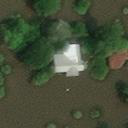

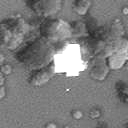

AttributeError: dtype

In [20]:
# class 1
applygabor("E:/Codes/Pattern Recognition/Dataset/test_another/damage/-93.66592_30.201557.jpeg")

(128, 128)


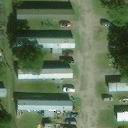

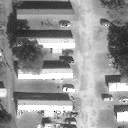

AttributeError: dtype

In [21]:
# class 0
applygabor("E:/Codes/Pattern Recognition/Dataset/test_another/no_damage/-95.07949_30.031162.jpeg")

## Canny Edge Detection: Feature extraction
Explanation: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

In [22]:
def simple_edge_detection(image):
    edges_detected = cv2.Canny(image , 100, 200)
    images = [image , edges_detected]
    location = [121, 122]
    for loc, edge_image in zip(location, images):
        plt.subplot(loc)
        plt.imshow(edge_image)
    plt.show()

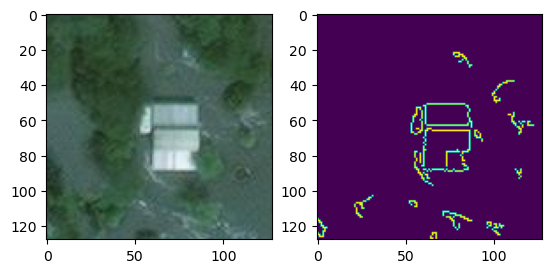

In [23]:
img = cv2.imread('E:/Codes/Pattern Recognition/Dataset/test/damage/-93.6654_30.140094.jpeg')
simple_edge_detection(img)

C:\Users\ritik\AppData\Local\Temp\ipykernel_21060\1865690825.py:39: RuntimeWarning: invalid value encountered in divide
  G = G / G.max() * 255


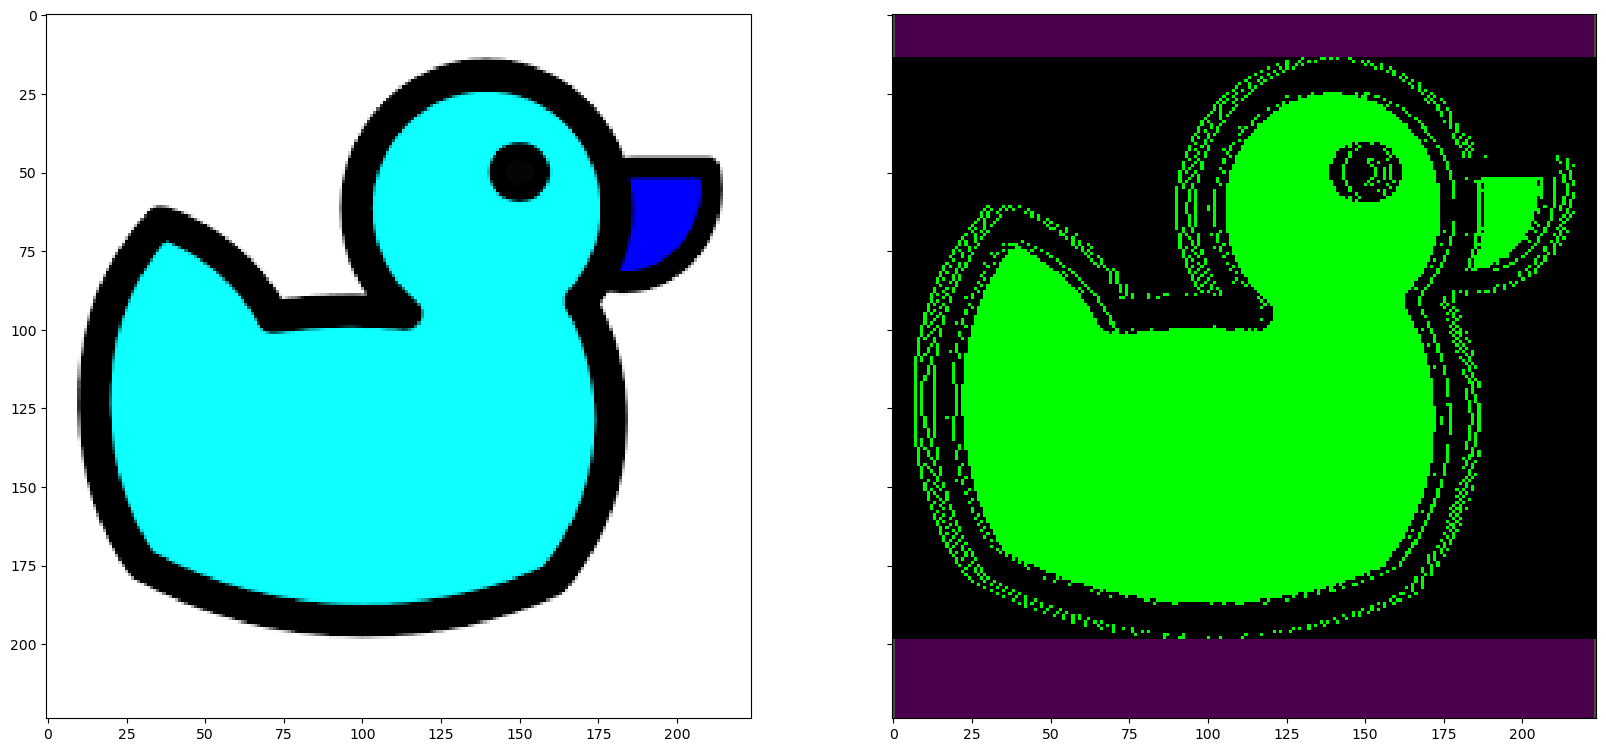

In [26]:
from scipy import ndimage
from scipy.ndimage import convolve
import numpy as np

class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return

    # Applying Gaussian Kernel for noise reduction
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g

    # Applying Sobel Filters for Gradient Calculation
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.convolve(img, Kx)
        Iy = ndimage.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)

    # Non Max Suppression of edges
    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                    #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    # Doubling the Threashold
    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    # Edge detection using Hysteresis
    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                                or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                                or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img

    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):
            self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final


img = cv2.imread('C:/Users/ritik/Downloads/download.png',1)
canny = cannyEdgeDetector(img)
img_canny = canny.detect()
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,10))
ax[1].imshow(img_canny, cmap='gray')
ax[0].imshow(img)